In [51]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch
from torch import nn

In [52]:
train_data = datasets.MNIST(root='data', train=True, download=True, transform= ToTensor())
test_data = datasets.MNIST(root='data', train=False, download=True, transform= ToTensor())

In [53]:
image, label = train_data[0]
image.shape

torch.Size([1, 28, 28])

In [54]:
print(train_data.classes)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


Image shape: torch.Size([1, 28, 28])


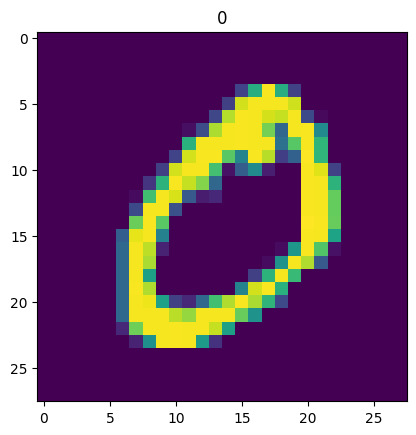

In [55]:
import matplotlib.pyplot as plt
image, label = train_data[1]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze()) # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(label);

In [56]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False)

In [57]:
from torch import nn
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [58]:
model0 = FashionMNISTV0(input_shape=784,hidden_units=10,output_shape=10)
model0.to('cpu')

FashionMNISTV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [59]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [60]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model0.parameters(),lr=0.1)

In [61]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time


In [62]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model0.train()
        # 1. Forward pass
        y_pred = model0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0, 0
    model0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = model0(X)

            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                           end=train_time_end_on_cpu,
                                           device=str(next(model0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.40316 | Test loss: 0.29412, Test acc: 91.68%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.30784 | Test loss: 0.28649, Test acc: 91.88%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.29578 | Test loss: 0.28646, Test acc: 91.99%

Train time on cpu: 31.019 seconds


In [63]:
def preprocess_custom_image(image_path):
    """
    Converts any image into MNIST-compatible tensor:
    - Handles RGB / Grayscale
    - Resizes to 28x28
    - Auto-inverts background if needed
    - Normalizes properly
    """

    # Load image
    image = Image.open(image_path)

    # Convert to grayscale
    image = ImageOps.grayscale(image)

    # Resize to MNIST dimensions
    image = image.resize((28, 28))

    # Convert to tensor
    image_tensor = transforms.ToTensor()(image)

    # Auto-invert if background is white
    # MNIST digits are white on black background
    if image_tensor.mean() > 0.5:
        image_tensor = 1.0 - image_tensor

    # Normalize (MNIST stats)
    image_tensor = transforms.Normalize(
        mean=(0.1307,),
        std=(0.3081,)
    )(image_tensor)

    # Add batch dimension
    image_tensor = image_tensor.unsqueeze(0)

    return image_tensor


In [73]:
from PIL import Image, ImageOps
from torchvision import transforms

# Redefine preprocess_custom_image within this cell to include the necessary imports
# (This is done because the original function definition in KpiQfnpEpAdR was missing these imports,
# and we are constrained to modify only this cell XGcc3_SK5yhZ.)
def preprocess_custom_image(image_path):
    """
    Converts any image into MNIST-compatible tensor:
    - Handles RGB / Grayscale
    - Resizes to 28x28
    - Auto-inverts background if needed
    - Normalizes properly
    """

    # Load image
    image = Image.open(image_path)

    # Convert to grayscale
    image = ImageOps.grayscale(image)

    # Resize to MNIST dimensions
    image = image.resize((28, 28))

    # Convert to tensor
    image_tensor = transforms.ToTensor()(image)

    # Auto-invert if background is white
    # MNIST digits are white on black background
    if image_tensor.mean() > 0.5:
        image_tensor = 1.0 - image_tensor

    # Normalize (MNIST stats)
    image_tensor = transforms.Normalize(
        mean=(0.1307,),
        std=(0.3081,)
    )(image_tensor)

    # Add batch dimension
    image_tensor = image_tensor.unsqueeze(0)

    return image_tensor

image_path = "/content/192869.png"  # change this

image_tensor = preprocess_custom_image(image_path)

print("Processed image shape:", image_tensor.shape)

Processed image shape: torch.Size([1, 1, 28, 28])


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

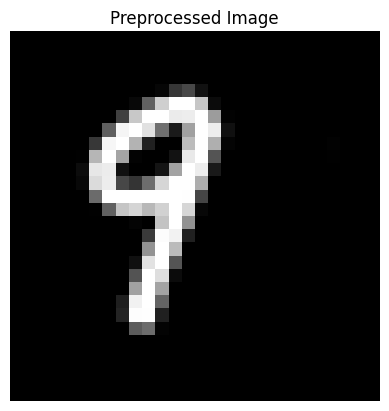

In [74]:
plt.imshow(image_tensor.squeeze(), cmap="gray")
plt.title("Preprocessed Image")
plt.axis("off")


In [75]:
model0.eval()

with torch.inference_mode():
    logits = model0(image_tensor)
    prediction = logits.argmax(dim=1).item()

print(f"Predicted digit: {prediction}")

Predicted digit: 8
